<div style="text-align: center; font-size: 40px; font-weight: bold; color: green;">NEURAL MODELS</div>

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob

import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.stats import skew, kurtosis
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

<div style="font-weight: bold; font-size: 20px; color: green;">Load and Split Data</div>

In [2]:
# Load csv into df
df = pd.read_csv("audio_features.csv")

In [3]:
# Confirm df successfully loaded
df.head()

,rms_mean,rms_std,rms_max,rms_min,rms_skew,rms_kurtosis,zcr_mean,zcr_std,zcr_max,zcr_min,...,chroma_cqt10_skew,chroma_cqt10_kurtosis,chroma_cqt11_mean,chroma_cqt11_std,chroma_cqt11_min,chroma_cqt11_max,chroma_cqt11_skew,chroma_cqt11_kurtosis,filename,label
0,0.020713,0.014193,0.082619,0.003360,1.230320,1.489241,0.063742,0.028594,0.180176,0.009277,...,1.058182,-0.281785,0.214191,0.208159,0.030045,1.000000,2.521216,6.545759,classical.00072.wav,classical
1,0.029710,0.016566,0.099159,0.003439,0.860528,0.802966,0.063705,0.029301,0.186035,0.016602,...,0.814741,-0.757137,0.231473,0.156859,0.012648,1.000000,1.604591,3.426752,classical.00030.wav,classical
2,0.029499,0.020230,0.108574,0.002613,0.913463,0.553828,0.086217,0.029102,0.198242,0.026367,...,0.053029,-1.472771,0.240709,0.130534,0.019854,1.000000,1.129880,1.973275,classical.00010.wav,classical
3,0.044323,0.033052,0.179927,0.005385,1.417183,1.916810,0.075839,0.027404,0.160645,0.017090,...,0.937287,-0.514512,0.324423,0.201675,0.049456,1.000000,1.519959,2.455826,classical.00038.wav,classical
4,0.013986,0.009004,0.052015,0.001963,0.919975,1.215321,0.070119,0.035137,0.187012,0.002930,...,1.458900,1.617633,0.200864,0.175486,0.017570,0.813503,1.400728,1.204524,classical.00094.wav,classical


In [4]:
# Split data
target = "label"
X = df.drop(columns=[
    "filename", "label", 'chroma_cqt7_max', "chroma_cqt9_max", 'chroma_cqt4_max',
    'chroma_cqt1_max', 'chroma_cqt8_max', 'chroma_cqt8_max', 'chroma_cqt2_max', 'chroma_cqt0_max',
    'chroma_cqt10_max', 'chroma_cqt5_max', 'chroma_cqt11_max'] # Drop Features with least importance
)

y = df[target]
# Check status
print(f"Feature matrix shape:", X.shape)
print(f"Target vector shape:", y.shape)

Feature matrix shape: (999, 212)
Target vector shape: (999,)


In [5]:
# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Check results
print(f"Training set shape:", X_train.shape)
print(f"Training test set shape:", X_test.shape)

Training set shape: (799, 212)
Training test set shape: (200, 212)


<div style="color:green; font-weight: bold; font-size: 20px">Feature Scaling & Encoding</div>

In [7]:
# Instantiate Scaler
scaler = StandardScaler().fit(X_train)
# Scale whole training set only
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Confirm scaling
print(f"X_train_scaled mean", np.mean(X_train_scaled)) # Should be close to zero
print(f"X_train_scaled std", np.std(X_train_scaled)) # Should be close to one

X_train_scaled mean 3.6368606507191e-17
X_train_scaled std 1.0


<div style="text-align: center; color: red; font-weight: bold; font-size: 40px">Multi-layer Perceptrons(MLPs) for Classification</div>

In [9]:
# Instatiate encoder
le = LabelEncoder()
# Encode target
y_encoded = le.fit_transform(y_train)

In [10]:
# Instantiate
clf = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation="relu",
    solver="adam",
    alpha=0.0001, # L2, Regularization to prevent overfitting
    learning_rate="constant",
    max_iter=500,
    random_state=42
    
)
# Fit data
clf.fit(X_train_scaled, y_encoded)

MLPClassifier(max_iter=500, random_state=42)

In [11]:
# Predict
clf_pred = clf.predict(X_test_scaled)
# Decoded predictions
decoded_predictions = le.inverse_transform(clf_pred)
# Test accuracy
print(f"MLP accuracy:", accuracy_score(y_test, decoded_predictions))

MLP accuracy: 0.77


**Note**
- Accuracy of 77. Not too bad

In [12]:
# #Hyper-parameter tuning
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'sgd'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant', 'adaptive'],
#     'max_iter': [1800, 2000]
# }
# # Set up grid search
# grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring="accuracy")
# grid_search.fit(X_train_scaled, y_encoded)

# # Instantiate best classifier
# best_clf = grid_search.best_estimator_

# # Output best params
# print("Best parameters:", grid_search.best_params_)

In [13]:
# Instantiate best classifier
best_clf = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate="constant",
    max_iter=1800, # Increase max_iter if needed
    random_state=42,
)
# Fit data
best_clf.fit(X_train_scaled, y_encoded)

MLPClassifier(max_iter=1800, random_state=42)

In [14]:
# Predict
best_pred = best_clf.predict(X_test_scaled)
# Decode Predictions
bpred_decoded = le.inverse_transform(best_pred)
# Evaluate
print("Accuracy:", accuracy_score(y_test, bpred_decoded))

Accuracy: 0.77


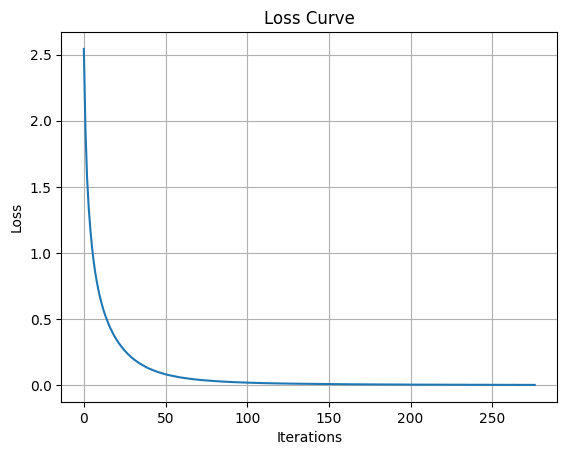

In [15]:
# Plot the learning curve
plt.plot(best_clf.loss_curve_)
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

**Question**
- Could RandomizedCV be more accurate?